#Estimando Preços das Casas da Califórnia com Aprendizado Multi-tarefa

**Nome: **


# Enunciado

O Dataset que iremos trabalhar contém o preço mediano das casas de quarteirões na California.
Iremos usar uma rede neural para predizer esses preços, dado como entrada features como número total de salas, quartos e moradores nas casas do quarteirão.

O modelo será treinado com duas funções de perda, uma para um classificador binário e outra para um regressor.
Em tempo de inferência, o classificador binário primeiramente prediz se o valor da casa é maior que 500 mil.
- Se sim, a predição final será 500 mil.
- Se não, a predição final será a predita pelo regressor.

[Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) será a métrica oficial.

O Exercicio com menor MAE será o ganhador de 0.5 ponto na nota final.


# Dicas:

1. Recomenda-se normalizar os dados de entrada e saída.
1. Não se deve usar os exemplos de validação ou teste para cálculo do valores de normalização (min, max, média, std, etc).
1. Lembre de desnormalizar os preços de saída na hora de calcular as métricas.
1. Recomenda-se usar como loss a entropia cruzada para o classificador binário e a MSE para o regressor.
1. Recomenda-se usar uma combinação (soma ponderada) da loss do classificador com a loss do regressor.
1. A loss do regressor só deve ser aplicada nos exemplos cujo target é menor que 500 mil dolares.
1. Pode-se usar a sigmoid + entropia cruzada para fazer o regressor. Isso só funciona se os targets (preços) estiverem normalizados entre 0 e 1. Neste caso, pode-se usar BCE loss do pytorch: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss


# Extras
- Dataset descrito no google ML crash course:
  - https://developers.google.com/machine-learning/crash-course/california-housing-data-description
- Dataset via Scikit-learn:
  - https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py
- Dataset via Pratap (possui post Medium):
  - https://github.com/gurupratap-matharu/machine-learning-regression

## 1. Importação de pacotes

Procure deixar aqui apenas os pacotes que de fato são utilizados no notebook. Evite utilizar importações no estilo de importar tudo com uso de asterisco.

In [5]:
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn import metrics

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import mean_absolute_error

In [6]:
torch.manual_seed(1)

In [7]:
!pip install neptune-client==0.9.1

  Using cached https://files.pythonhosted.org/packages/b6/25/757d8828a31dba3e684ac2bbc29b5fee54ec1d5961333c5ba18fb5dcf67f/neptune-client-0.9.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/21/ed/03b0c36b5bcafbe2938ed222f9a164a6c0367ce99a9d2d502e462853571d/bravado-11.0.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/45/0b/38b06fd9b92dc2b68d58b75f900e97884c45bedd2ff83203d933cf5851c9/future-0.18.2.tar.gz
  Using cached https://files.pythonhosted.org/packages/3f/32/d5d3cab27fee7f6b22d7cd7507547ae45d52e26030fa77d1f83d0526c6e5/PyJWT-2.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/08/33/80e0d4f60e84a1ddd9a03f340be1065a2a363c47ce65c4bd3bae65ce9631/websocket_client-0.58.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a6/99/98019716955ba243657daedd1de8f3a88ca1f5b75057c38e959db22fb87b/GitPython-3.1.14-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9a/67/7e8406a29b6c45

In [8]:
import neptune.new as neptune

# Como obter seu API token do Neptune:
# https://docs.neptune.ai/administration/security-and-privacy/how-to-find-and-set-neptune-api-token
run = neptune.init(project='d230640/Aula5-Exercicio', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZTg1OGU3Yi1jOWE1LTRjMjEtYTJjNS1hMjMwM2Y3NDRjOTUifQ==')

https://app.neptune.ai/d230640/Aula5-Exercicio/e/AUL1-7


## 2. Carregamento e leitura e eventual limpeza do dataset

Aqui é onde é lido o dataset, muitas vezes original, sem ainda estar no formato do pytorch

In [9]:
# Leitura do dataset
df_train = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
df_test = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

### 2.0 Vizualização do Dataset

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [11]:
print(df_train.shape)
print(df_test.shape)

(17000, 9)
(3000, 9)


In [12]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [13]:
df_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


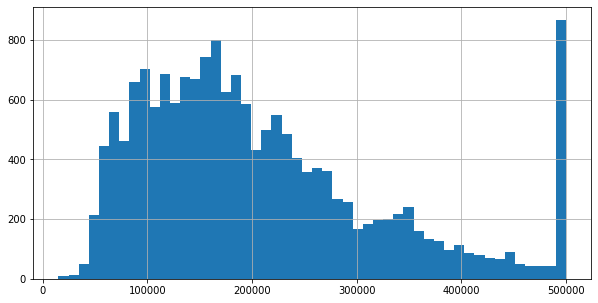

In [14]:
df_train.median_house_value.hist(bins=50, figsize=(10, 5))
plt.show()

Esse pico no valor que mostra o enteresse de adicionar a classificação entre valores abaixo e acima de 500mil

### 2.1 Criação do dataset do PyTorch

Visualizar:
- tamanho
- tipo da variável do x e do y
Se for tensores:
- shape do x e do y
- dtype do x e do y

In [15]:
# creating tensor from dataframe 
x = torch.tensor(df_train.values, dtype=torch.float32)
x_test = torch.tensor(df_test.values, dtype=torch.float32)


# Split target
y = x[:,df_train.shape[1]-1].reshape(df_train.shape[0],1)
x = x[:,:df_train.shape[1]-1]

y_test = x_test[:,df_test.shape[1]-1].reshape(df_test.shape[0],1)
x_test = x_test[:, :-1]

print(f'x_train.shape: {x.shape}')
print(f'y_train.shape: {y.shape}')
print(f'x_test.shape {x_test.shape}')
print(f'y_test.shape {y_test.shape}')

x_train.shape: torch.Size([17000, 8])
y_train.shape: torch.Size([17000, 1])
x_test.shape torch.Size([3000, 8])
y_test.shape torch.Size([3000, 1])


#### Adicionar colunas das classes
0 - classe menor que 50mil
1 - classe maior que 50mil 

In [16]:
is_500mil = y >= 500000
c = is_500mil.double()
y = torch.cat((y,c),1)
print(y.shape)

is_500mil = y_test >= 500000
c = is_500mil.double()
y_test = torch.cat((y_test,c),1)
print(y_test.shape)

torch.Size([17000, 2])
torch.Size([3000, 2])


#### Vizualização

In [17]:
print('tamanho=',len(x))
print ('x type', x.type())
print ('y type', y.type())
print ('x shape', x.shape)
print ('y shape', y.shape)
print ('x dtype', x.dtype)
print ('y dtype', y.dtype)

tamanho= 17000
x type torch.FloatTensor
y type torch.DoubleTensor
x shape torch.Size([17000, 8])
y shape torch.Size([17000, 2])
x dtype torch.float32
y dtype torch.float64


#### Separação train e validação

In [18]:
# Parameters
TRAIN_SIZE = 0.8

In [19]:
# Split data in train and test
index = torch.randperm(len(x), dtype=torch.long)

n_train = int(len(x)*TRAIN_SIZE)

# train
x_train = x[index[:n_train]]
y_train = y[index[:n_train]]

# val
x_val = x[index[n_train:]]
y_val = y[index[n_train:]]

print ('x_train=',x_train.shape)
print ('y_train=',y_train.shape)
print ('x_val=',x_val.shape)
print ('y_val=',y_val.shape)
x_train.type()
x.type()

x_train= torch.Size([13600, 8])
y_train= torch.Size([13600, 2])
x_val= torch.Size([3400, 8])
y_val= torch.Size([3400, 2])


'torch.FloatTensor'

In [20]:
x_train_min, _ = torch.min(x_train,0)
x_train_max, _ = torch.max(x_train,0)
x_train = (x_train - x_train_min)/(x_train_max-x_train_min)

y_train_min, _ = torch.min(y_train[:,0],0)
y_train_max, _ = torch.max(y_train[:,0],0)
y_train[:,0] = (y_train[:,0] - y_train_min)/(y_train_max - y_train_min)

In [21]:
x_val = (x_val - x_train_min)/(x_train_max-x_train_min)
y_val[:,0] = (y_val[:,0] - y_train_min)/(y_train_max - y_train_min)

x_test = (x_test - x_train_min)/(x_train_max-x_train_min)
y_test[:,0] = (y_test[:,0] - y_train_min)/(y_train_max - y_train_min)

In [22]:
if torch.cuda.is_available():
  dev = 'cuda:0'
else:
  dev = 'cpu'
print(dev)
device = torch.device(dev)

cuda:0


In [23]:
batch_size = 50

In [24]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        self.data = x
        self.target = y
            
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        x = self.data[index]
        p_regr = self.target[index, 0]
        l_clas = self.target[index, 1]
        return (x, p_regr, l_clas)

dataset_train = MyDataset(x_train, y_train)
dataset_val = MyDataset(x_val, y_val)
dataset_test = MyDataset(x_test, y_test)

In [25]:
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


print(f'Número de minibatchs de treinamento: {len(loader_train)}')
print(f'Número de minibatchs de treinamento: {len(loader_val)}')

x_train_i, y_train_class_i, y_train_regre_i = next(iter(loader_train))
print(f'\nDimenssões dos dados de um minibatch: {x_train_i.size()}')

Número de minibatchs de treinamento: 272
Número de minibatchs de treinamento: 68

Dimenssões dos dados de um minibatch: torch.Size([50, 8])


In [26]:
print(x_train_i.shape, y_train_class_i.shape, y_train_regre_i.shape)

torch.Size([50, 8]) torch.Size([50]) torch.Size([50])


In [27]:
x_val_i, y_val_class_i, y_val_regre_i = next(iter(loader_val))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))


Dimensões dos dados de um minibatch: torch.Size([13600, 8])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [28]:
x_val_i, y_val_class_i, y_val_regre_i = next(iter(loader_test))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))


Dimensões dos dados de um minibatch: torch.Size([13600, 8])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


# Modelo

In [29]:
class Model(torch.nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.dense_classification = torch.nn.Sequential(
      torch.nn.Linear(8,25),
      torch.nn.ReLU(),
      torch.nn.Linear(25,2),
    )

    self.dense_regression = torch.nn.Sequential(
      torch.nn.Linear(8,25),
      torch.nn.ReLU(),
      torch.nn.Linear(25,100),
      torch.nn.Dropout(0.2), #50 % probability 
      torch.nn.ReLU(),
      torch.nn.Linear(100,500),
      torch.nn.Dropout(0.2),
      torch.nn.ReLU(),
      torch.nn.Linear(500,100),
      torch.nn.Dropout(0.2),
      torch.nn.ReLU(),
      torch.nn.Linear(100,25),
      torch.nn.ReLU(),
      torch.nn.Linear(25,1),
    )

  def forward(self,x):
    x_class = self.dense_classification(x)
    x_regre = self.dense_regression(x)
    return x_class, x_regre


model = Model()
model.to(device)
print(model)

Model(
  (dense_classification): Sequential(
    (0): Linear(in_features=8, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=2, bias=True)
  )
  (dense_regression): Sequential(
    (0): Linear(in_features=8, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=100, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=500, bias=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=500, out_features=100, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=100, out_features=25, bias=True)
    (12): ReLU()
    (13): Linear(in_features=25, out_features=1, bias=True)
  )
)


# Treinamento

In [30]:
n_epochs = 1000
learning_rate = 0.1

criterion_regre =  torch.nn.MSELoss()
criterion_class = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_mae = torch.nn.L1Loss()

In [31]:
def denormalization(house_price, max_value,min_value):
  final_price = (house_price * (max_value - min_value)) + min_value
  return final_price

# Laço de Treinamento

In [32]:
best_valid_loss = 10e9
train_hist_loss = []
train_hist_loss_class = []
train_hist_loss_reg = []

val_hist_loss = []
val_hist_loss_class = []
val_hist_loss_reg = []

alpha = 0.8

for i in range(n_epochs+1):
  accumulated_loss = 0
  accumulated_loss_class = 0
  accumulated_loss_reg = 0
  accumulated_accuracy = 0
  accumulated_mae = 0

  model.train()
  for x_train_i,y_train_regre_i,y_train_class_i in loader_train:
    x_train_i = x_train_i.to(device)
    y_train_class_i = y_train_class_i.to(device)
    y_train_regre_i = y_train_regre_i.to(device)
    
    # predict da rede
    output_class, output_regre = model(x_train_i)    
    
    batch_loss_class = criterion_class(output_class,y_train_class_i.long())
    batch_loss_reg = criterion_regre(output_regre[y_train_class_i==0].squeeze(1).float(),y_train_regre_i[y_train_class_i==0].float())  # Método de restrição para regressão baseado no do colega Orlem
    batch_loss = (1-alpha)*batch_loss_class + alpha*batch_loss_reg
    
    bach_accuracy = (output_class.argmax(dim=1) == y_train_class_i).sum()
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    accumulated_loss += batch_loss.item()
    accumulated_loss_class += batch_loss_class.item()
    accumulated_loss_reg += batch_loss_reg.item()
    accumulated_accuracy += bach_accuracy 

    denorm_y_train_regre_i = denormalization(y_train_regre_i,y_train_max, y_train_min)
    denorm_output_regre = denormalization(output_regre,y_train_max, y_train_min)

    accumulated_mae += mean_absolute_error(denorm_y_train_regre_i.cpu().detach(),denorm_output_regre.cpu().detach())


  train_loss = accumulated_loss/len(loader_train.dataset)
  train_hist_loss.append(train_loss)
  train_hist_loss_class.append(accumulated_loss_class)
  train_hist_loss_reg.append(accumulated_loss_reg)
  train_total_accuracy = accumulated_accuracy/len(loader_train.dataset)
  train_total_mae = accumulated_mae/len(loader_train)

  run['Train/Loss'].log(train_loss)
  run['Train/Accuracy'].log(train_total_accuracy)
  run['Train/MAE'].log(train_total_mae)

#-------------------------------------------------------------------------------------------

  # Laço de Validação, um a cada época.
  accumulated_loss = 0
  accumulated_loss_class = 0
  accumulated_loss_reg = 0
  accumulated_accuracy = 0
  accumulated_mae = 0
  model.eval()
  with torch.no_grad():
    for x_val_i, y_val_regre_i, y_val_class_i in loader_val:
      x_val_i = x_val_i.to(device)
      y_val_class_i = y_val_class_i.to(device)
      y_val_regre_i = y_val_regre_i.to(device)

      output_class, output_regre = model(x_val_i)

      batch_loss_class = criterion_class(output_class,y_val_class_i.long())
      batch_loss_reg = criterion_regre(output_regre[y_val_class_i==0].squeeze(1).float(),y_val_regre_i[y_val_class_i==0].float())
      batch_loss = (1-alpha)*batch_loss_class + alpha*batch_loss_reg

      bach_accuracy = (output_class.argmax(dim=1) == y_val_class_i).sum()
      accumulated_loss += batch_loss.item()
      accumulated_loss_class += batch_loss_class.item()
      accumulated_loss_reg += batch_loss_reg.item()
      accumulated_accuracy += bach_accuracy 

      denorm_y_val_regre_i = denormalization(y_val_regre_i,y_train_max, y_train_min)
      denorm_output_regre = denormalization(output_regre,y_train_max, y_train_min)
      accumulated_mae += mean_absolute_error(denorm_y_val_regre_i.cpu().detach(),denorm_output_regre.cpu().detach())



  val_loss = accumulated_loss/len(loader_val.dataset)
  val_hist_loss.append(val_loss)
  val_hist_loss_class.append(accumulated_loss_class)
  val_hist_loss_reg.append(accumulated_loss_reg)
  val_total_accuracy = accumulated_accuracy/len(loader_val.dataset)
  val_total_mae = accumulated_mae/len(loader_val)

  run['Validation/Loss'].log(val_loss)
  run['Validation/Accuracy'].log(val_total_accuracy)
  run['Validation/MAE'].log(val_total_mae)


  if(i%50==0):
    print(f'Época: {i:d}/{n_epochs:d} \t| Train Loss: {train_loss:.6f} \t Val Loss: {val_loss:.6f} \t| Train Accuracy: {train_total_accuracy} \t Val Accuracy: {val_total_accuracy} \t| Train Total Mae: {train_total_mae} \t Val Total Mae: {val_total_mae}')

  if val_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    best_valid_loss = val_loss

Época: 0/1000 	| Train Loss: 0.001476 	 Val Loss: 0.001297 	| Train Accuracy: 0.9506617188453674 	 Val Accuracy: 0.9508823156356812 	| Train Total Mae: 92327.57427131209 	 Val Total Mae: 88961.45452665442
Época: 50/1000 	| Train Loss: 0.000636 	 Val Loss: 0.000620 	| Train Accuracy: 0.9678676128387451 	 Val Accuracy: 0.9655882120132446 	| Train Total Mae: 45601.82804917281 	 Val Total Mae: 44036.46525620405
Época: 100/1000 	| Train Loss: 0.000596 	 Val Loss: 0.000576 	| Train Accuracy: 0.9686764478683472 	 Val Accuracy: 0.9673529267311096 	| Train Total Mae: 43987.06795424518 	 Val Total Mae: 40670.900430836395
Época: 150/1000 	| Train Loss: 0.000572 	 Val Loss: 0.000580 	| Train Accuracy: 0.9687499403953552 	 Val Accuracy: 0.964411735534668 	| Train Total Mae: 42055.73816521138 	 Val Total Mae: 38633.29458409926
Época: 200/1000 	| Train Loss: 0.000557 	 Val Loss: 0.000520 	| Train Accuracy: 0.9694852828979492 	 Val Accuracy: 0.9688234925270081 	| Train Total Mae: 41950.81595818013 	 V

''

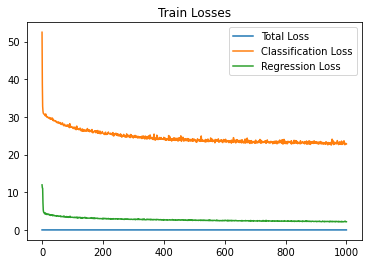

In [33]:
plt.plot(train_hist_loss)
plt.plot(train_hist_loss_class)
plt.plot(train_hist_loss_reg)
plt.legend(['Total Loss', 'Classification Loss', 'Regression Loss'], loc=1)
plt.title('Train Losses')
''

''

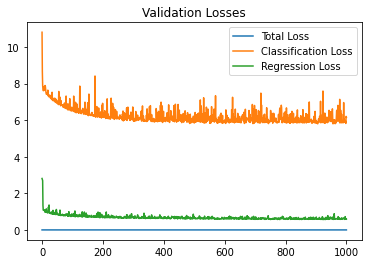

In [34]:
plt.plot(val_hist_loss)
plt.plot(val_hist_loss_class)
plt.plot(val_hist_loss_reg)
plt.legend(['Total Loss', 'Classification Loss', 'Regression Loss'], loc=1)
plt.title('Validation Losses')
''

In [35]:
param_saved = torch.load('/content/best_model.pt')
model.load_state_dict(param_saved)

<All keys matched successfully>

In [37]:
accumulated_loss = 0
accumulated_loss_class = 0
accumulated_loss_reg = 0
accumulated_accuracy = 0
accumulated_mae = 0
model.eval()
with torch.no_grad():
  for x_test_i, y_test_regre_i, y_test_class_i in loader_test:
    x_test_i = x_test_i.to(device)
    y_test_class_i = y_test_class_i.to(device)
    y_test_regre_i = y_test_regre_i.to(device)

    output_class, output_regre = model(x_test_i)

    batch_loss_class = criterion_class(output_class,y_test_class_i.long())
    batch_loss_reg = criterion_regre(output_regre[y_test_class_i==0].squeeze(1).float(),y_test_regre_i[y_test_class_i==0].float())
    batch_loss = (1-alpha)*batch_loss_class + alpha*batch_loss_reg

    bach_accuracy = (output_class.argmax(dim=1) == y_test_class_i).sum()
    accumulated_loss += batch_loss.item()
    accumulated_loss_class += batch_loss_class.item()
    accumulated_loss_reg += batch_loss_reg.item()
    accumulated_accuracy += bach_accuracy 

    denorm_y_test_regre_i = denormalization(y_test_regre_i,y_train_max, y_train_min)
    denorm_output_regre = denormalization(output_regre,y_train_max, y_train_min)
    accumulated_mae += mean_absolute_error(denorm_y_test_regre_i.cpu().detach(),denorm_output_regre.cpu().detach())

test_loss = accumulated_loss/len(loader_test.dataset)
test_hist_loss.append(test_loss)
test_hist_loss_class.append(accumulated_loss_class)
test_hist_loss_reg.append(accumulated_loss_reg)
test_total_accuracy = accumulated_accuracy/len(loader_val.dataset)
test_total_mae = accumulated_mae/len(loader_test)

run['Test/Loss'].log(test_loss)
run['Test/Accuracy'].log(test_total_accuracy)
run['Test/MAE'].log(test_total_mae)


print(f'Test Loss: {test_loss:.6f} \t| Test Accuracy: {test_total_accuracy} \t| Test Total Mae: {test_total_mae}')


Test Loss: 0.000488 	| Test Accuracy: 0.8573529124259949 	| Test Total Mae: 35229.30352213541
